## steps:
- take the cifar10 dataset and a trained model on it
- show some example images
- compute LIME, SHAP, and 2 gradient based explanations and show it on 1x4 frame?
- also show RISE?

In [1]:
from tqdm.auto import tqdm

from functools import partial

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, FashionMNIST
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor

import numpy as np; np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)
torch.set_printoptions(sci_mode=False)

import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb, rgb2gray, label2rgb
from lime.wrappers.scikit_image import SegmentationAlgorithm
from numpy import linalg as la

In [2]:
def get_LIME_classifier(lime_expl, label_x0, x0):
    """
    returns lime explainer as a functional form g
    :param lime_expl: returned object from lime explainer.explain_instance
    :param label_x0: model predicted label of x0
    :param x0: the instance (standardized) -- note that it is not used other than just knowing its shape
    :return:
    """
    import sklearn
    features_weights = [x[1] for x in lime_expl.local_exp[label_x0]]
    features_indices = [x[0] for x in lime_expl.local_exp[label_x0]]    # feature' indices
    intercept = lime_expl.intercept[label_x0]
    coef = np.zeros(len(x0))
    coef[features_indices] = features_weights
    if hasattr(lime_expl, 'perfect_local_concordance') and lime_expl.perfect_local_concordance:
        # print('have perfect_local_concordance classifier!')
        g = lime.lime_base.TranslatedRidge(alpha=1.0)
        g.x0 = np.zeros(len(x0))
        g.x0 = lime_expl.x0
        # g.x0[features_indices] = lime_expl.x0[features_indices]
        g.f_x0 = lime_expl.predict_proba[label_x0]
        g.coef_ = g.ridge.coef_ = coef
        g.intercept_ = g.ridge.intercept_ = intercept
        # print('g.x0', g.x0)
        # print('g.f_x0', g.f_x0)
        # print('g.coef_', g.coef_)
        # print('g.intercept_', g.intercept_)
    else:
        g = sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True)#, normalize=False)
        g.coef_ = coef
        g.intercept_ = intercept
    return g

## Data preprocessing and downloading

Files already downloaded and verified
Files already downloaded and verified
[inputs] dtype: torch.float32, shape: torch.Size([512, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([512])


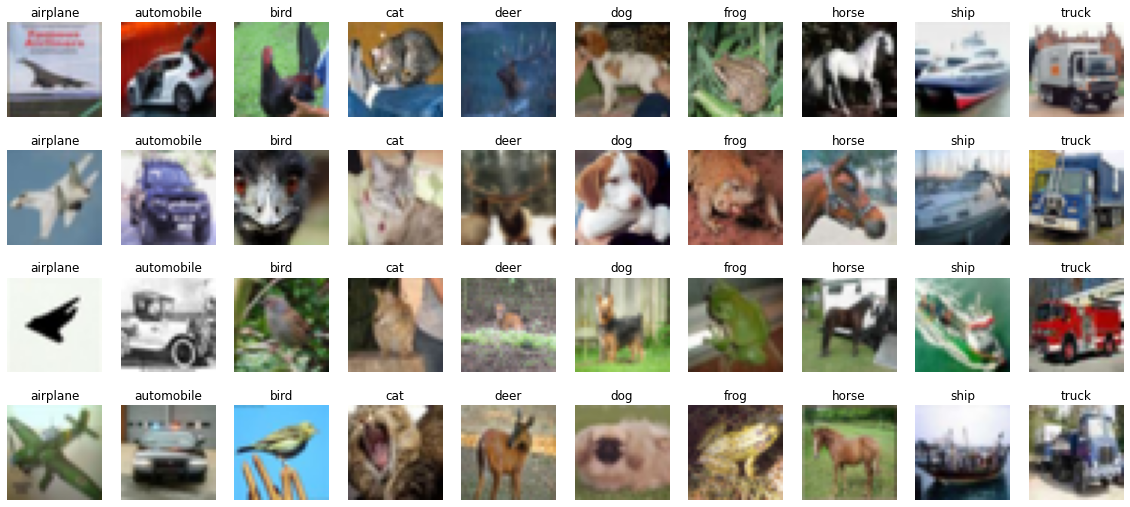

In [3]:
transforms = {
  "train": Compose([
#     RandomCrop(32, padding=4),  # introduces some black borders
#     RandomHorizontalFlip(),
    ToTensor(),
  ]),
  "test": ToTensor(),
}

dataset = {}
for split in ["train", "test"]:
    dataset[split] = CIFAR10(
    root="./data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
    )
    
    

## define dataloaders as well
dataflow = {}
for split in ['train', 'test']:
    dataflow[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )
    
for inputs, targets in dataflow["train"]:
    print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
    print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
    break

    

# visualize 4 samples from each of the 10 classes
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
    if len(samples[label]) < 4:
        samples[label].append(image)
        
plt.figure(figsize=(20, 9))
for index in range(40):
    label = index % 10
    image = samples[label][index // 10]

    # Convert from CHW to HWC for visualization
    image = image.permute(1, 2, 0)

    # Convert from class index to class name
    label = dataset["test"].classes[label]

    # Visualize the image
    plt.subplot(4, 10, index + 1)
    plt.imshow(image, cmap='gray')
    plt.title(label)
    plt.axis("off")
plt.show()

In [4]:
from model_vgg import VGG_CIFAR
MODEL_PATH = '/Users/swagatam/Desktop/random/verified-explanations/doing-basic-things/saved_models_pytorch/cifar10/vgg_cifar10_trained.pth'
model = VGG_CIFAR()
model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
print(f"model is in gpu? {next(model.parameters()).is_cuda}")

model is in gpu? False


## Inspect model predictions

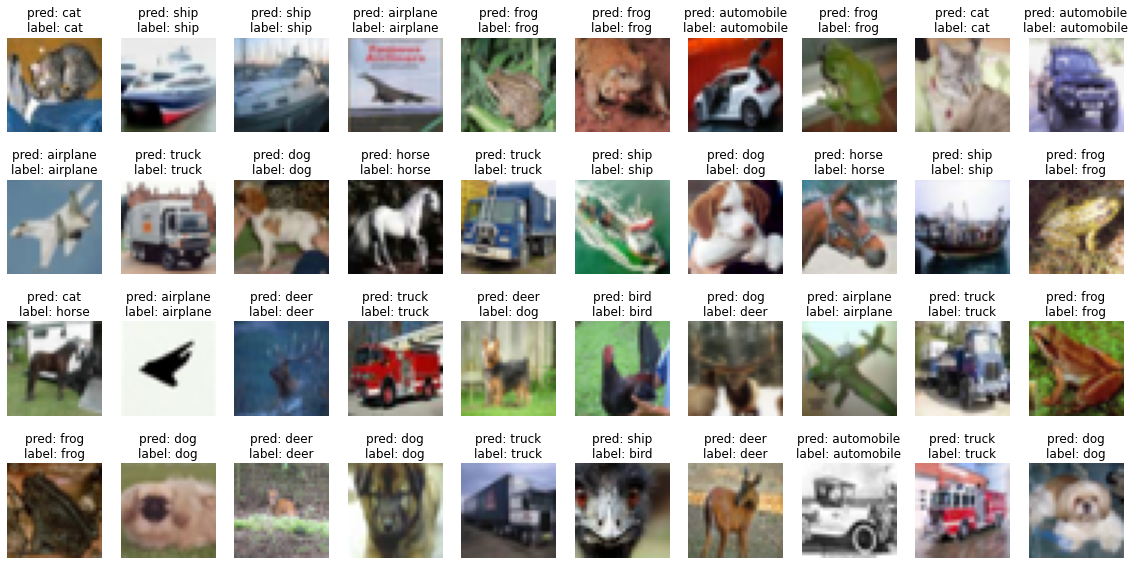

In [5]:
plt.figure(figsize=(20, 10))
for index in range(40):
    image, label = dataset["test"][index]

    # Model inference
    model.eval()
    with torch.torch.no_grad():
        pred = model(image.unsqueeze(dim=0))
        pred = pred.argmax(dim=1)

    # Convert from CHW to HWC for visualization
    image = image.permute(1, 2, 0)

    # Convert from class indices to class names
    pred = dataset["test"].classes[pred]
    label = dataset["test"].classes[label]

    # Visualize the image
    plt.subplot(4, 10, index + 1)
    plt.imshow(image)
    plt.title(f"pred: {pred}" + "\n" + f"label: {label}")
    plt.axis("off")
plt.show()

In [6]:
from utils import _predict_proba, _single_predict_proba, tensor_imshow, VisualizeImageGrayscale

In [7]:
# instantiate using "model"
predict_proba = partial(_predict_proba, model=model)
single_predict_proba = partial(_single_predict_proba, model=model)

# here image is a numpy batch array
def batch_predict(images):
    # print(images.shape)  # (10, 32, 32, 3)
    batch = torch.stack(tuple(torch.from_numpy(i) for i in images), dim=0)
    batch = batch.permute(0, 3, 1, 2)
    # print(f"batch shape={batch.shape}")
    return predict_proba(batch).numpy()

In [8]:
for image_batch, targets_batch in dataflow["test"]:
    print("[inputs] dtype: {}, shape: {}".format(image_batch.dtype, image_batch.shape))
    print("[targets] dtype: {}, shape: {}".format(targets_batch.dtype, targets_batch.shape))
    break

[inputs] dtype: torch.float32, shape: torch.Size([512, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([512])


idx = 70, img = 


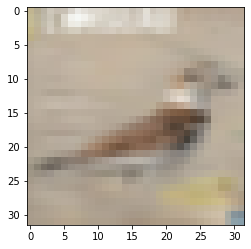

label = 2 (bird)
pred prob = tensor([    0.0018,     0.0003,     0.9834,     0.0011,     0.0015,     0.0074,
            0.0005,     0.0006,     0.0032,     0.0003]), pred label = 2 (bird)


In [110]:
random_idx = np.random.choice(image_batch.shape[0])
random_idx = 72
random_idx = 431 # the dog image
random_idx = 98 # the cartoonish aeroplane
random_idx = 70 # bird,  ship -- 472
print(f'idx = {random_idx}, img = ')
tensor_imshow(image_batch[random_idx])
print(f'label = {targets_batch[random_idx]} ({dataset["train"].classes[targets_batch[random_idx]]})')
pred = single_predict_proba(image_batch[random_idx])
print(f'pred prob = {pred}, pred label = {pred.argmax()} ({dataset["train"].classes[pred.argmax()]})')

## LIME explanation

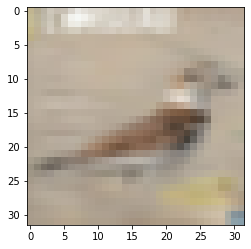

lime for idx=70 with ground truth label=2 (bird)


  0%|          | 0/5000 [00:00<?, ?it/s]

toplabelinp: 2


In [111]:
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
nlabels = 10
datatype = np.float32
nsamples = 5000


imgno = random_idx
inputimg = dataset["test"][imgno][0]  # tensor of shape (3, 32, 32)
inputimglabel = dataset["test"][imgno][1]
tensor_imshow(inputimg)
# img = gray2rgb(inputimg[0]).astype(datatype)
img = inputimg.permute(1, 2, 0).numpy()  # img must be (32, 32, 3) numpy array, otherwise segmenter won't work
nrows = img.shape[0]
print(f"lime for idx={imgno} with ground truth label={inputimglabel} ({dataset['train'].classes[inputimglabel]})")


# compute the lime explanation for this particular image
explainer = lime_image.LimeImageExplainer(verbose=False)
explanation = explainer.explain_instance(img, # requires numpy array!
                                         batch_predict,  # classification function
                                         top_labels=nlabels,
                                         hide_color=0,
                                         num_samples=nsamples,
                                         segmentation_fn=segmenter)

num_segments = len(np.unique(explanation.segments))
toplabelinp = explanation.top_labels[0]
print(f'toplabelinp: {toplabelinp}')

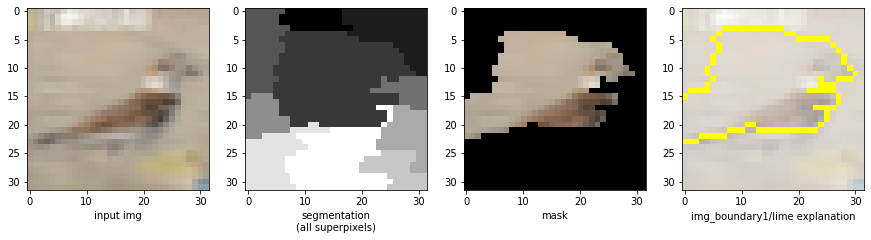

In [112]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], # masks for this particular label
                                            positive_only=True,
                                            num_features=2, # number of superpixels to include in explanation
                                            hide_rest=False #if True => make the non-explanation part of the return image gray
                                           )
img_boundry1 = mark_boundaries(temp/2 + 0.5, mask) 

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[3].imshow(img_boundry1, cmap='gray')
axes[3].set_xlabel('img_boundary1/lime explanation')
axes[0].imshow(temp)
axes[0].set_xlabel('input img')
axes[2].imshow(img*mask[..., None], cmap='gray')
limemask = mask
limeexp = img*mask[..., None]
axes[2].set_xlabel('mask')

# axes[1].imshow(img*(segmenter(img)>=0)[..., None], cmap='gray') 
axes[1].imshow(segmenter(img), cmap='gray')
axes[1].set_xlabel('segmentation\n(all superpixels)')
plt.show()

In [113]:
explanation.local_exp[toplabelinp]

[(2, 0.2202820233837668),
 (5, 0.11176056750125903),
 (0, 0.1086697786030779),
 (3, -0.07521444425465608),
 (4, 0.06468405778964983),
 (9, 0.05085020134115377),
 (6, 0.03820483256231215),
 (7, 0.029853578690530146),
 (8, 0.01699116887709807),
 (1, 0.0070429976791256035)]

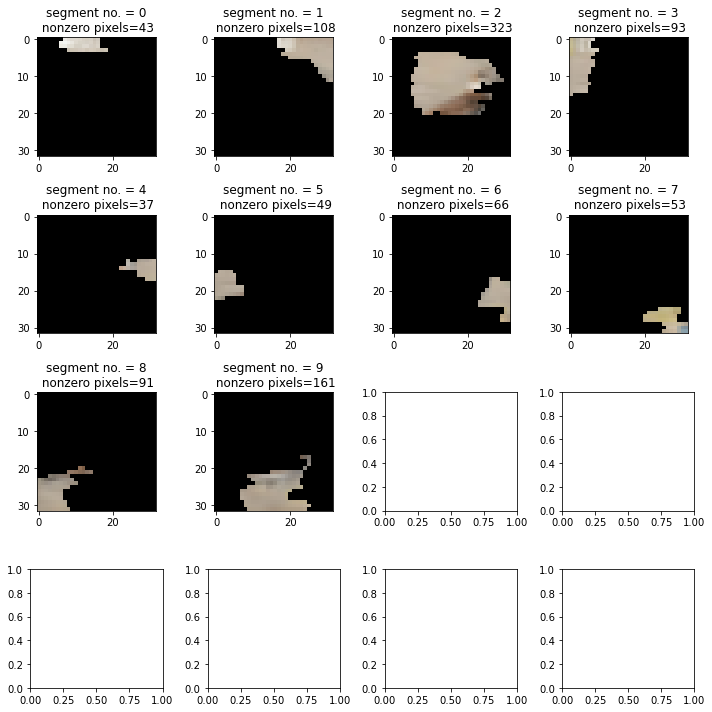

In [114]:
segments = np.unique(segmenter(img))
segimg = explanation.segments
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for seg in segments:
#     print(f'segment no. = {seg}')
    thissegimg = img * (segimg == seg)[..., None]
    axes[seg//4][seg%4].imshow(thissegimg, cmap='gray')
    axes[seg//4][seg%4].set_title(f'segment no. = {seg}\n nonzero pixels={(segimg == seg).sum()}')
fig.tight_layout()
plt.show()

In [115]:
explanation.local_pred # how is this generated???

array([0.42210993])

In [116]:
func = get_LIME_classifier(explanation, toplabelinp, np.unique(segments))
func.predict([np.ones(num_segments)])

array([0.42210993])

In [117]:
explanation.local_exp[toplabelinp]

[(2, 0.2202820233837668),
 (5, 0.11176056750125903),
 (0, 0.1086697786030779),
 (3, -0.07521444425465608),
 (4, 0.06468405778964983),
 (9, 0.05085020134115377),
 (6, 0.03820483256231215),
 (7, 0.029853578690530146),
 (8, 0.01699116887709807),
 (1, 0.0070429976791256035)]

## SHAP explanation
partition explainer blog: https://towardsdatascience.com/shaps-partition-explainer-for-language-models-ec2e7a6c1b77

estimating shap values: https://mindfulmodeler.substack.com/p/why-shap-needs-to-be-estimated

https://mindfulmodeler.substack.com/p/10-ways-to-estimate-shap

In [118]:
topk = 1
batch_size = 128
n_evals = 5000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(16, 16)", image_batch.permute(0, 2, 3, 1)[0].shape)
# masker_blur = shap.maskers.Image("inpaint_telea", image_batch.permute(0, 2, 3, 1)[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(batch_predict,
                           masker_blur, 
                           output_names=dataset['test'].classes)

# feed only one image
# here we explain two images using 5000 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    inputimg.unsqueeze(0).permute(0, 2, 3, 1),
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:14, 14.38s/it]                                     


In [119]:
inputimg.unsqueeze(0).permute(0, 2, 3, 1).shape

torch.Size([1, 32, 32, 3])

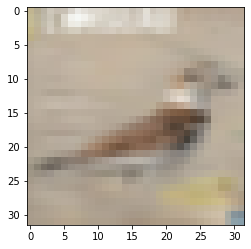

In [120]:
tensor_imshow(shap_values.data.permute(0, 3, 1, 2)[0])

In [121]:
shap_values.output_names

['bird']

In [122]:
exps = shap_values.values[0]
exps.shape

(32, 32, 3, 1)

In [123]:
exp = exps[:,:,:,0]

In [124]:
# exp

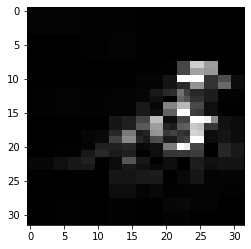

In [125]:
plt.imshow(VisualizeImageGrayscale(exp), cmap='gray')

In [129]:
shapviz = VisualizeImageGrayscale(exp)

In [130]:
shaponimg = img * (shapviz >= 0.05)[..., None]

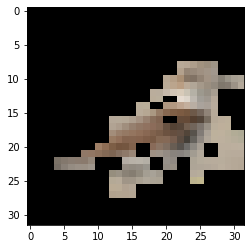

In [131]:
plt.imshow(shaponimg)

In [132]:
# plt.hist(np.sort(shapviz.flatten())[::-1], bins=100)

In [133]:
# ((shapviz>0) * (shapviz<0.01)).sum()

In [146]:
plt.rcParams.update({'font.size': 14})

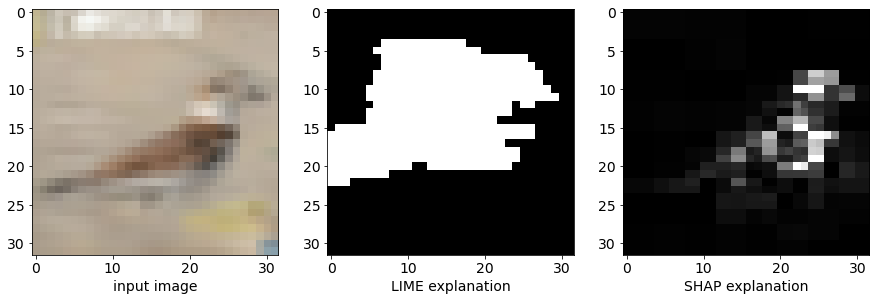

In [150]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(temp)
axes[0].set_xlabel('input image')

axes[1].imshow(limemask, cmap='gray')
# axes[1].imshow(limeexp)
axes[1].set_xlabel('LIME explanation')#\n(top 2 superpixels)')

axes[2].imshow(shapviz, cmap='gray')
axes[2].set_xlabel('SHAP explanation')

fig.savefig('image1.pdf')
# plt.show()

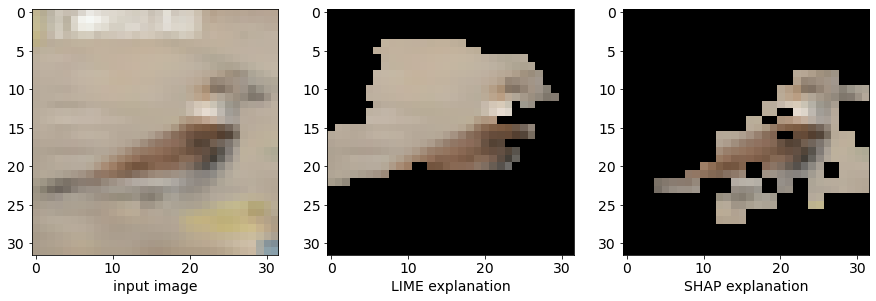

In [153]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(temp)
axes[0].set_xlabel('input image')

# axes[1].imshow(limemask, cmap='gray')
axes[1].imshow(limeexp)
axes[1].set_xlabel('LIME explanation')#\n(top 2 superpixels)')

axes[2].imshow(shaponimg)
axes[2].set_xlabel('SHAP explanation')

fig.savefig('image2.pdf')
# plt.show()